In [2]:
import mdtraj as md
import numpy as np

# Load your structure
traj = md.load('COVID_ATP_RNA.pdb')

# Select NSP13 amino acids
nsp13_indices = traj.topology.select('chainid 0')  # Adjust as needed

# Select RNA phosphate atoms
phosphate_indices = traj.topology.select('name P')  # Selecting phosphate atoms

# Select uracil oxygens (explicitly specifying atom names)
uracil_oxygen_indices = traj.topology.select('resname U and (name O2 or name O4)')  # Adjust based on actual atom names

# Create lists to hold the close amino acids
close_amino_acids_phosphate = set()
close_amino_acids_uracil = set()

# Compute the distances
for nsp13_index in nsp13_indices:
    nsp13_atom_position = traj.xyz[0][nsp13_index]

    # Check proximity to phosphate atoms
    for phosphate_index in phosphate_indices:
        phosphate_atom_position = traj.xyz[0][phosphate_index]
        distance = np.linalg.norm(nsp13_atom_position - phosphate_atom_position)
        if distance <= 0.5:
            close_amino_acids_phosphate.add(traj.topology.atom(nsp13_index).residue.name)

    # Check proximity to uracil oxygens
    for uracil_oxygen_index in uracil_oxygen_indices:
        uracil_oxygen_position = traj.xyz[0][uracil_oxygen_index]
        distance = np.linalg.norm(nsp13_atom_position - uracil_oxygen_position)
        if distance <= 0.5:
            close_amino_acids_uracil.add(traj.topology.atom(nsp13_index).residue.name)

# Print the results
print("Amino acids in NSP13 within 0.5 nm of RNA phosphate atoms:")
print(close_amino_acids_phosphate)

print("Amino acids in NSP13 within 0.5 nm of uracil oxygens:")
print(close_amino_acids_uracil)

uracil_oxygen_indices = traj.topology.select('resname U')


Amino acids in NSP13 within 0.5 nm of RNA phosphate atoms:
{'ASN', 'CYS', 'HIS', 'PRO', 'ALA', 'TYR', 'ARG', 'THR', 'SER'}
Amino acids in NSP13 within 0.5 nm of uracil oxygens:
{'ASN', 'GLU', 'SER', 'ASP', 'LEU', 'HIS', 'ALA', 'THR', 'TYR', 'ARG', 'MET', 'PRO', 'LYS'}


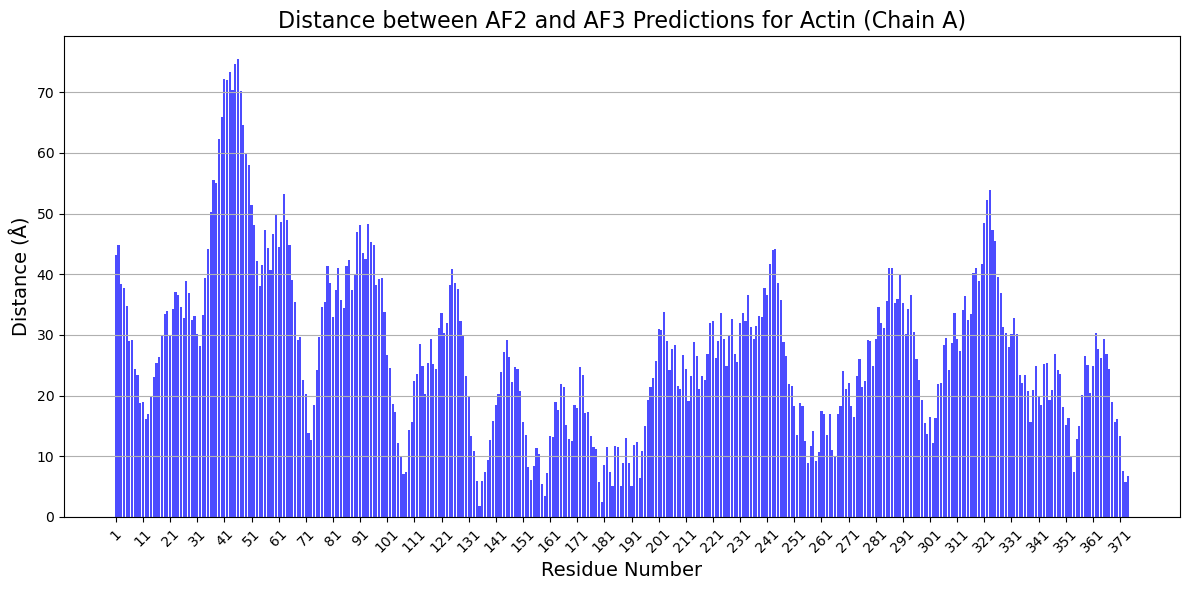

In [13]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt

# Load the PDB files
af2_file = 'ActinProfilin_923b1_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb'  # AF2 model
af3_file = 'Alphafold3_actin_profilin_atp.pdb'  # AF3 model

# Parse the PDB files
parser = PDB.PDBParser(QUIET=True)
structure_af2 = parser.get_structure('AF2', af2_file)
structure_af3 = parser.get_structure('AF3', af3_file)

# Select chain A
chain_af2 = structure_af2[0]['A']
chain_af3 = structure_af3[0]['A']

# Get atom coordinates
coords_af2 = np.array([residue['CA'].get_coord() for residue in chain_af2 if 'CA' in residue])
coords_af3 = np.array([residue['CA'].get_coord() for residue in chain_af3 if 'CA' in residue])

# Check the lengths to align correctly
min_length = min(len(coords_af2), len(coords_af3))
coords_af2 = coords_af2[:min_length]
coords_af3 = coords_af3[:min_length]

# Compute distances between corresponding residues
distances = np.linalg.norm(coords_af2 - coords_af3, axis=1)

# Create a bar chart of distances
residue_numbers = np.arange(1, min_length + 1)

plt.figure(figsize=(12, 6))
plt.bar(residue_numbers, distances, color='blue', alpha=0.7)
plt.xlabel('Residue Number', fontsize=14)
plt.ylabel('Distance (Å)', fontsize=14)
plt.title('Distance between AF2 and AF3 Predictions for Actin (Chain A)', fontsize=16)

# Adjust x-ticks for better visibility
plt.xticks(residue_numbers[::10], fontsize=10, rotation=45)  # Show every 10th residue number and rotate
plt.grid(axis='y')
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('Distance_Between_AF2_AF3.png', format='png')
plt.show()


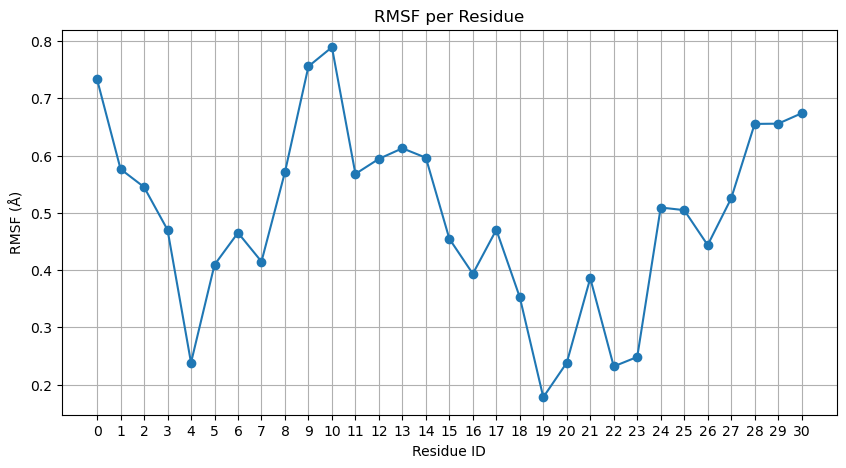

In [15]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load all PDB files
pdb_files = sorted(glob.glob('art-est_Alphafold2/*.pdb'))


trajectories = [md.load(pdb_file) for pdb_file in pdb_files]

# Concatenate all trajectories into one
all_trajectories = md.join(trajectories)

# Select the protein atoms
protein_indices = all_trajectories.topology.select('protein')

# Align to the first frame
md.rmsd(all_trajectories, all_trajectories, frame=0)

# Calculate RMSF
positions = all_trajectories.xyz[:, protein_indices, :]
mean_positions = np.mean(positions, axis=0)
rmsf = np.sqrt(np.mean((positions - mean_positions[np.newaxis, :, :])**2, axis=0))

# Get residue indices
# Convert the atoms to a list to enable indexing
atoms = list(all_trajectories.topology.atoms)
residue_indices = [atoms[i].residue.index for i in protein_indices]

# Create a unique list of residue indices
unique_residues = sorted(set(residue_indices))

# Average RMSF per residue
rmsf_per_residue = np.array([np.mean(rmsf[np.array(residue_indices) == res]) for res in unique_residues])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(unique_residues, rmsf_per_residue, marker='o')
plt.xlabel('Residue ID')
plt.ylabel('RMSF (Å)')
plt.title('Root Mean Squared Fluctuation per Residue')
plt.xticks(unique_residues)
plt.grid()

# Save the figure as a PNG file
plt.savefig('RMSF_Per_Residue.png', format='png')
plt.show()
